In [5]:
import cv2
import json
import argparse
import treepoem
import numpy as np
from matplotlib import pyplot as plt

from data_generator import gens, dims
from augmentations import augs


def load_json(fname, *args, **kwargs):
    with open(fname) as f:
        return json.load(f, *args, **kwargs)


def save_json(jd, fname, *args, indent=4, **kwargs):
    with open(fname, 'w') as f:
        json.dump(jd, f, *args, indent=indent, **kwargs)


def aligned_affine(bar, M, fix_position=True):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    
    height, width, _ = bar.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    
    if fix_position:
        M = M.copy()
        M[:,-1] *= 0
        M[:,-1] = -np.min(M@corners, axis=-1)

    new_sz = np.ceil(np.max(M@corners, axis=-1)).astype(np.int32)
    img = cv2.warpAffine(bar, M, new_sz)
    return img, M@corners


def generate_perspective_distort(img, alpha=0.1, beta=0.01):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    height, width, _ = img.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T

    M = np.zeros((3,3))
    M[:-1,:-1] = np.random.randn(2, 2)*alpha + np.eye(2)*(1.-alpha)
    M[-1, :-1] = beta*np.abs(np.random.randn(1,2))
    M[:-1,-1] *= 0
    M[-1,-1] = 1
    coords = (M@corners)[:-1]
    M[:-1,-1] = -np.min(coords, axis=-1)
    return M

def generate_aligned_perspective_distort(img, scale=0.1):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    height, width, _ = img.shape
    corners = np.array([[x*width, y*height] for x, y in zip(xps, yps)])
    corners_old = corners.copy()

    dx, dy = np.random.exponential(scale=width*scale, size=corners.shape).T

    corners[0,0] -= dx[0]
    corners[0,1] += dy[0]

    corners[1,0] -= dx[1]
    corners[1,1] -= dy[1]

    corners[2,0] += dx[2]
    corners[2,1] -= dy[2]

    corners[3,0] += dx[3]
    corners[3,1] += dy[3]

    theta = np.math.pi*np.random.random()*2
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    corners = corners@R

    M = cv2.getPerspectiveTransform(corners_old.astype(np.float32), corners.astype(np.float32))

    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    M[:-1,-1] *= 0
    M[-1,-1] = 1
    coords = (M@corners)[:-1]
    M[:-1,-1] = -np.min(coords, axis=-1)
    coords = M@corners
    coords = coords[:-1]/coords[-1]

    new_sz = np.ceil(np.max(coords, axis=-1)).astype(np.int32)

    return M


def aligned_perspective(img, M):
    xps = [0, 0, 1, 1]
    yps = [1, 0, 0, 1]
    height, width, _ = img.shape
    corners = np.array([[x*width, y*height, 1] for x, y in zip(xps, yps)]).T
    coords = M@corners
    coords = coords[:-1]/coords[-1]
    
    new_sz = np.ceil(np.max(coords, axis=-1)).astype(np.int32)
    
    img = cv2.warpPerspective(img, M, new_sz)
    return img, coords


def coords_to_regions(coords, dimensions):
    res = []
    for i in range(len(coords)):
        ptsx, ptsy = coords[i]
        
        res.append({\
        'shape_attributes': {
            'name': 'polygon',
            'all_points_x': list(ptsx),
            'all_points_y': list(ptsy)
        },
        'region_attributes': {'barcode': dimensions[i]}})
    return res


def export(img, name, coords, dimensions):
    #np.clip(img, 0, 1)
    plt.imsave(f'{name}.jpg', img)
    res = {f'{name}.jpg813086': {'filename': f'../code/{name}.jpg',
    'size': 813086,
    'regions': coords_to_regions(coords, dimensions),
    'file_attributes': {}}}
    save_json(res, f'{name}.json')


def generate_distorted(barcode_types, content_barcodes, source_img=None, augms=[], distortions=None):
    # barimgs = [treepoem.generate_barcode(typ, content) for typ, content in zip(barcode_types, content_barcodes)]
    barimgs = [np.array(treepoem.generate_barcode(typ, content)) for typ, content in zip(barcode_types, content_barcodes)]
    for aug_name in augms:
        barimgs = [augs[aug_name](img) for img in barimgs]
    if distortions is None:
        distortions = [generate_aligned_perspective_distort(np.array(img)) for img in barimgs]
    # imgs, coords = zip(*[aligned_affine(np.array(img), dis) for img, dis in zip(barimgs, distortions)])
    imgs, coords = zip(*[aligned_perspective(np.array(img), dis) for img, dis in zip(barimgs, distortions)])
    # masks, _ = zip(*[aligned_affine(np.ones_like(img), dis) for img, dis in zip(barimgs, distortions)])
    masks, _ = zip(*[aligned_perspective(np.ones_like(img), dis) for img, dis in zip(barimgs, distortions)])
    
    if source_img is None:
        width, height, _ = np.max([img.shape for img in imgs], axis=0)*len(imgs)//3
        combined = np.zeros((width, height, 3), dtype=imgs[0].dtype)
    else:
        combined = plt.imread(source_img)[:,:,:3] if not isinstance(source_img, np.ndarray) else source_img
        width, height, _ = combined.shape

    for i in range(len(imgs)):
        w, h, _ = imgs[i].shape
        if width - w < 0 or height -h < 0:
            continue
        dw = np.random.randint(0, width - w)
        dh = np.random.randint(0, height - h)
        coords[i][0] += dh
        coords[i][1] += dw
        expanded_img = np.zeros_like(combined)
        expanded_img[dw:w+dw, dh:h+dh] = imgs[i]
        expanded_mask = np.zeros_like(combined)
        expanded_mask[dw:w+dw, dh:h+dh] = masks[i]
        combined = combined*(1-expanded_mask) + expanded_img
    return combined, coords


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(prog='Distorted barcode generator', description='''TODO''')
#     parser.add_argument('-c', '--config', help='json config to generate image with barcodes', type=str)
#     # parser.add_argument('-b', '--barcode_type', help='barcode type', type=str)
#     # parser.add_argument('-c', '--content_barcode', help='barcode content', type=str)
#     # parser.add_argument('-f', '--filename', help='name of the json markup and result img', type=str)
#     # parser.add_argument('-d', '--dimension', help='1d or 2d barcode', type=str)
#     parser.print_help()
#     args = parser.parse_args()

#     conf = load_json(args.config)
#     contents = conf.get('barcode_contents', None)
#     if contents is None:
#         contents = [gens[bar_type]() for bar_type in conf['barcode_types']]
#     img, coords = generate_distorted(conf['barcode_types'], contents, conf['source_img'],
#                                      augms=conf.get('augmentations', []))
#     dimensions = [dims[bar_type] for bar_type in conf['barcode_types']]
#     export(img, conf['name'], coords, dimensions)

#     # barimg = treepoem.generate_barcode(args.barcode_type, args.content_barcode)
#     # img, coords = aligned_affine(np.array(barimg), np.random.randn(2, 3))
#     # export(img, coords, args.filename, args.dimension)


In [9]:
barcode_types = ["ean13", "qrcode"]
barcode_contents = ["100000011111", "1", "110", "1", "1", "1", "1"]
barcode_dimensions = ["1d", "1d", "1d", "1d", "1d", "1d", "1d"]
source_img = "./example.jpg"
augmentations = ["Folding", "BadPhotoCopy", "LightingGradient"]
img, coords= generate_distorted(
    barcode_types=barcode_types,
    content_barcodes=barcode_contents,
    source_img=source_img,
    augms=augmentations
)

In [12]:
coords

(array([[294.73968656, 419.88686674, 367.66201539, 213.        ],
        [  5.        ,  83.14033606, 278.75481935, 194.6871183 ]]),
 array([[ 94.70769998,  10.        ,  39.02675539, 119.43088075],
        [260.49861977, 234.26050752, 138.        , 160.77564765]]))

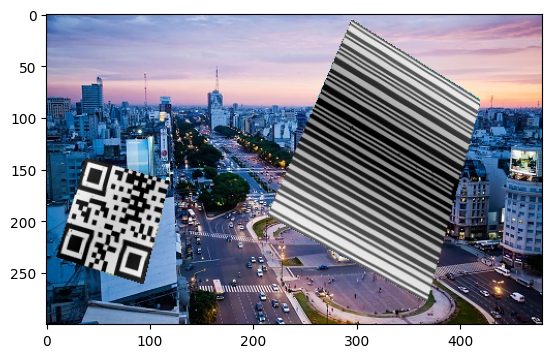

In [11]:
plt.imshow(img)